**This is a course project from udacity self-driving car nano-degree. In this project, students are given the german traffic sign data and required to using Convolutional Neural Network to classify it. It also gives a baseline implementation by [Pierre Sermanet](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf)**

## Step 0: Load and Preprocessing data
This step loads data file from the data file and preprocesses them. The data is assumed to be stored in the ```traffic-signs-data``` folder. The images are of size $32 \times 32 \times 3$. Training dataset has 39209 images, not too much. The testing dataset has 12630 images. The label are integer from one of the 43 traffic sign categories, like stop, children crossing etc.


In [1]:
import pickle
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import csv
import numpy as np
import random
# Visualizations will be shown in the notebook.
%matplotlib inline

# read data from the original dataset
training_file = './traffic-signs-data/train.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
# get image and label for traint and test dataset
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

# count the number of classes, number of training image, number of testing images
n_classes = len(set(y_train))
n_train = X_train.shape[0]
n_test = X_test.shape[0]

# read csv file with name for each class, for display purpose only
idx2name = [] # index to the name of the class
with open('./signnames.csv', 'r') as csvfile:
    # skip header
    csvfile.readline()
    lines = csvfile.readlines()
    for line in lines:
        idx2name.append(line.split(',')[1])

### Showing images in each category
Before doing any processing, let's first gain some intuition about the dataset. This code snippet shows four images in each class. From the dataset, we can see that the in each class, the size of the sign, lighting condition, viewing angle differs drastically. Therefore, it is necessary to preprocess the data. The preprocessing procedure will be introduced in latter sections. 

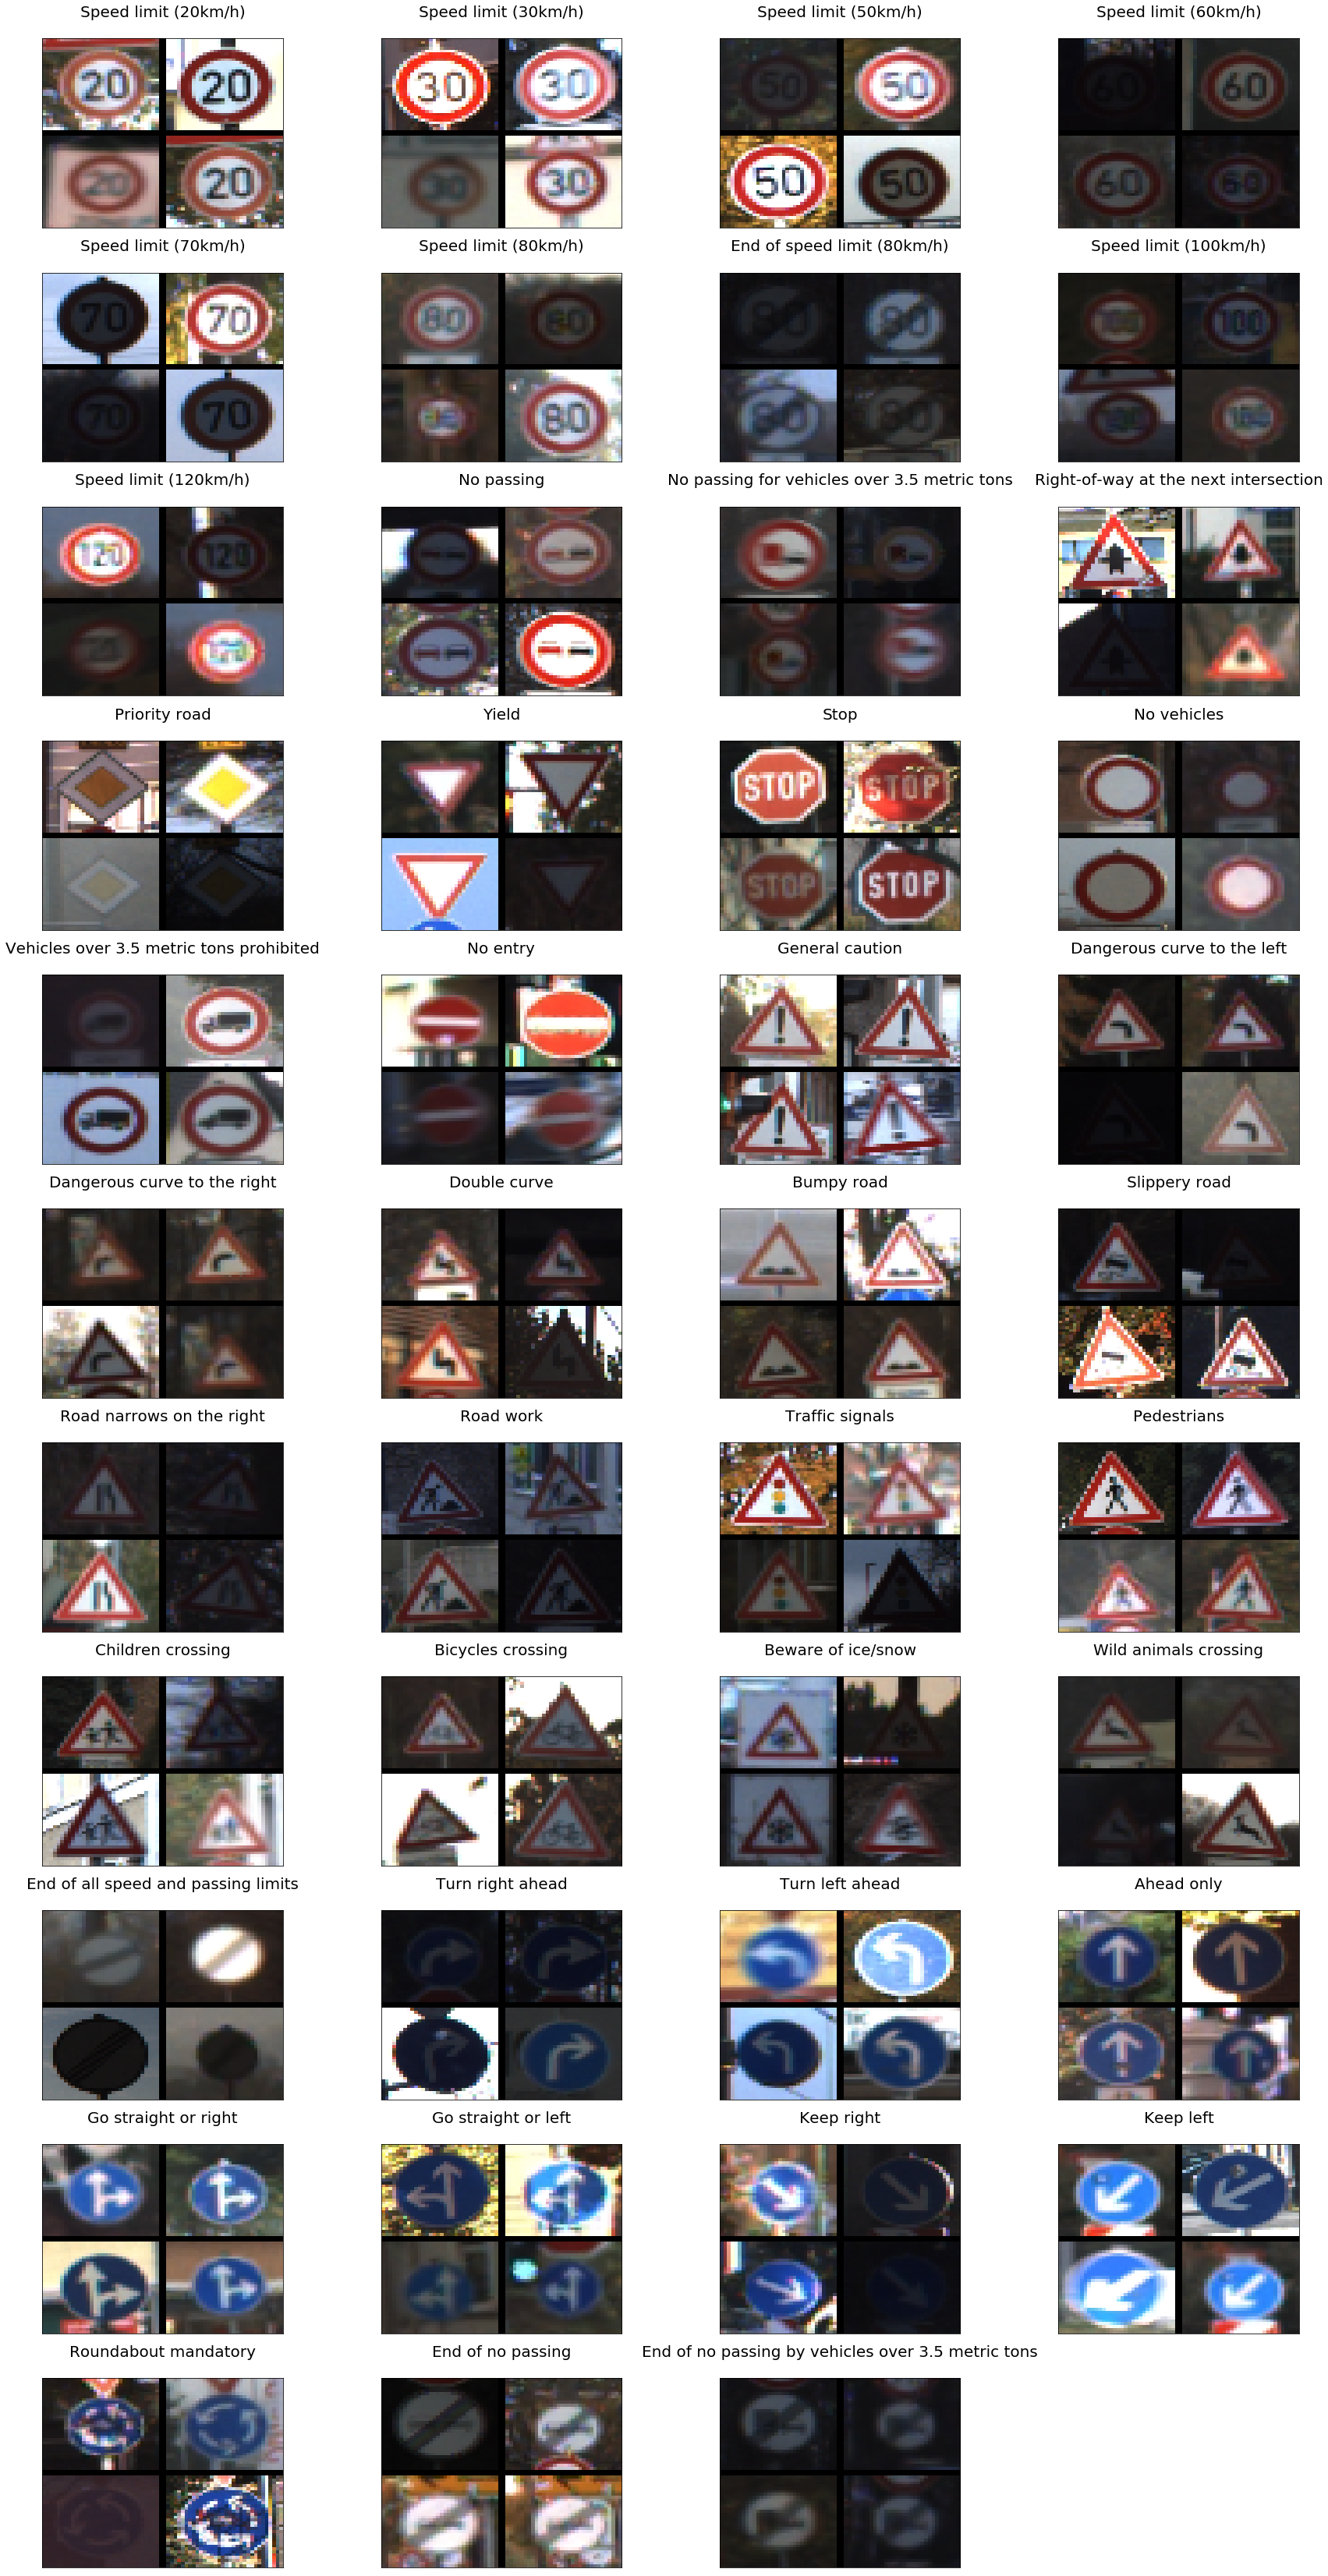

In [2]:
# calculate the index in each class
idxOfEachClass=[[] for i in range(n_classes)]
for i in range(n_train):
    idxOfEachClass[y_train[i]].append(i)
# draw images
fig1 = plt.figure(num=1, figsize=[24,46])
gs = gridspec.GridSpec(11, 4)
ax=[]
for ci in range(n_classes):
    row = (ci // 4)
    col = ci % 4
    # random choose images without replacement
    cidx = np.random.choice(idxOfEachClass[ci],4,replace=False)
    Image = np.zeros([66,66,3],dtype=np.uint8)
    # put small images into large images
    Image[0:32,0:32,:] = X_train[cidx[0],:,:,:]
    Image[34:66,0:32,:] = X_train[cidx[1],:,:,:]
    Image[0:32,34:66,:] = X_train[cidx[2],:,:,:]
    Image[34:66,34:66,:] = X_train[cidx[3],:,:,:]
    ax.append(fig1.add_subplot(gs[row, col]))
    ax[-1].set_title(idx2name[ci],{'fontsize':20})
    ax[-1].imshow(Image,interpolation='nearest',aspect='auto')
    ax[-1].get_xaxis().set_visible(False)
    ax[-1].get_yaxis().set_visible(False)
fig1.tight_layout()


### Class Distribution
Now we view distribution of the training and testing dataset. The train dataset is an inbalanced dataset. Some classes has less than 500 images, while some have over 2000 images. Usually, inbalance dataset can cause a lot of problems. For details about how to deal with this, you can check this [post](http://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/). Fortunately, the class distribution of training dataset is the same as testing dataset. Therefore, we do not need to explicitly deal with inbalance.

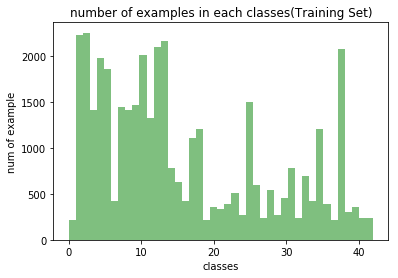

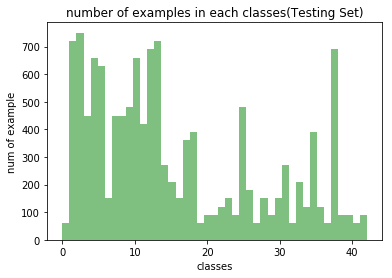

In [3]:
# visualize the number of train example in each class
fig2 = plt.figure(num=2)
histCount = [len(c) for c in idxOfEachClass]
n, bins, patches = plt.hist(y_train, n_classes, facecolor='green', alpha=0.5)
plt.xlabel('classes')
plt.ylabel('num of example')
plt.title('number of examples in each classes(Training Set)')

# visualize the number of test example in each class
fig3 = plt.figure(num=3)
histCount = [len(c) for c in idxOfEachClass]
n, bins, patches = plt.hist(y_test, n_classes, facecolor='green', alpha=0.5)
plt.xlabel('classes')
plt.ylabel('num of example')
plt.title('number of examples in each classes(Testing Set)')

### Show Preprocessing Effect
As mentioned previously, the images in the dataset have drastically different lighting condition. Some of them so dark that we can hardly see what it is using human eye. Therefore, we need to processin the dataset such that all of them have similar lighting condition. The [paper]() proposed to transform RGB image into YUV space and then do global and local contrast normalization on the Y channel only. The exact normalization method is [CLAHE](https://en.wikipedia.org/wiki/Adaptive_histogram_equalization), which is one of my favourite CV algorithm.

Some background about why normalize the Y channel. When we talked about normalization, we usually mean normalize the brightness of the image. The brightness is affected by the illumination while the color is usually not affected by illumination(we assume the light is white). Therefore, there is a need to extract the brightness signal from the RGB image, normalize it, which is Y channel.

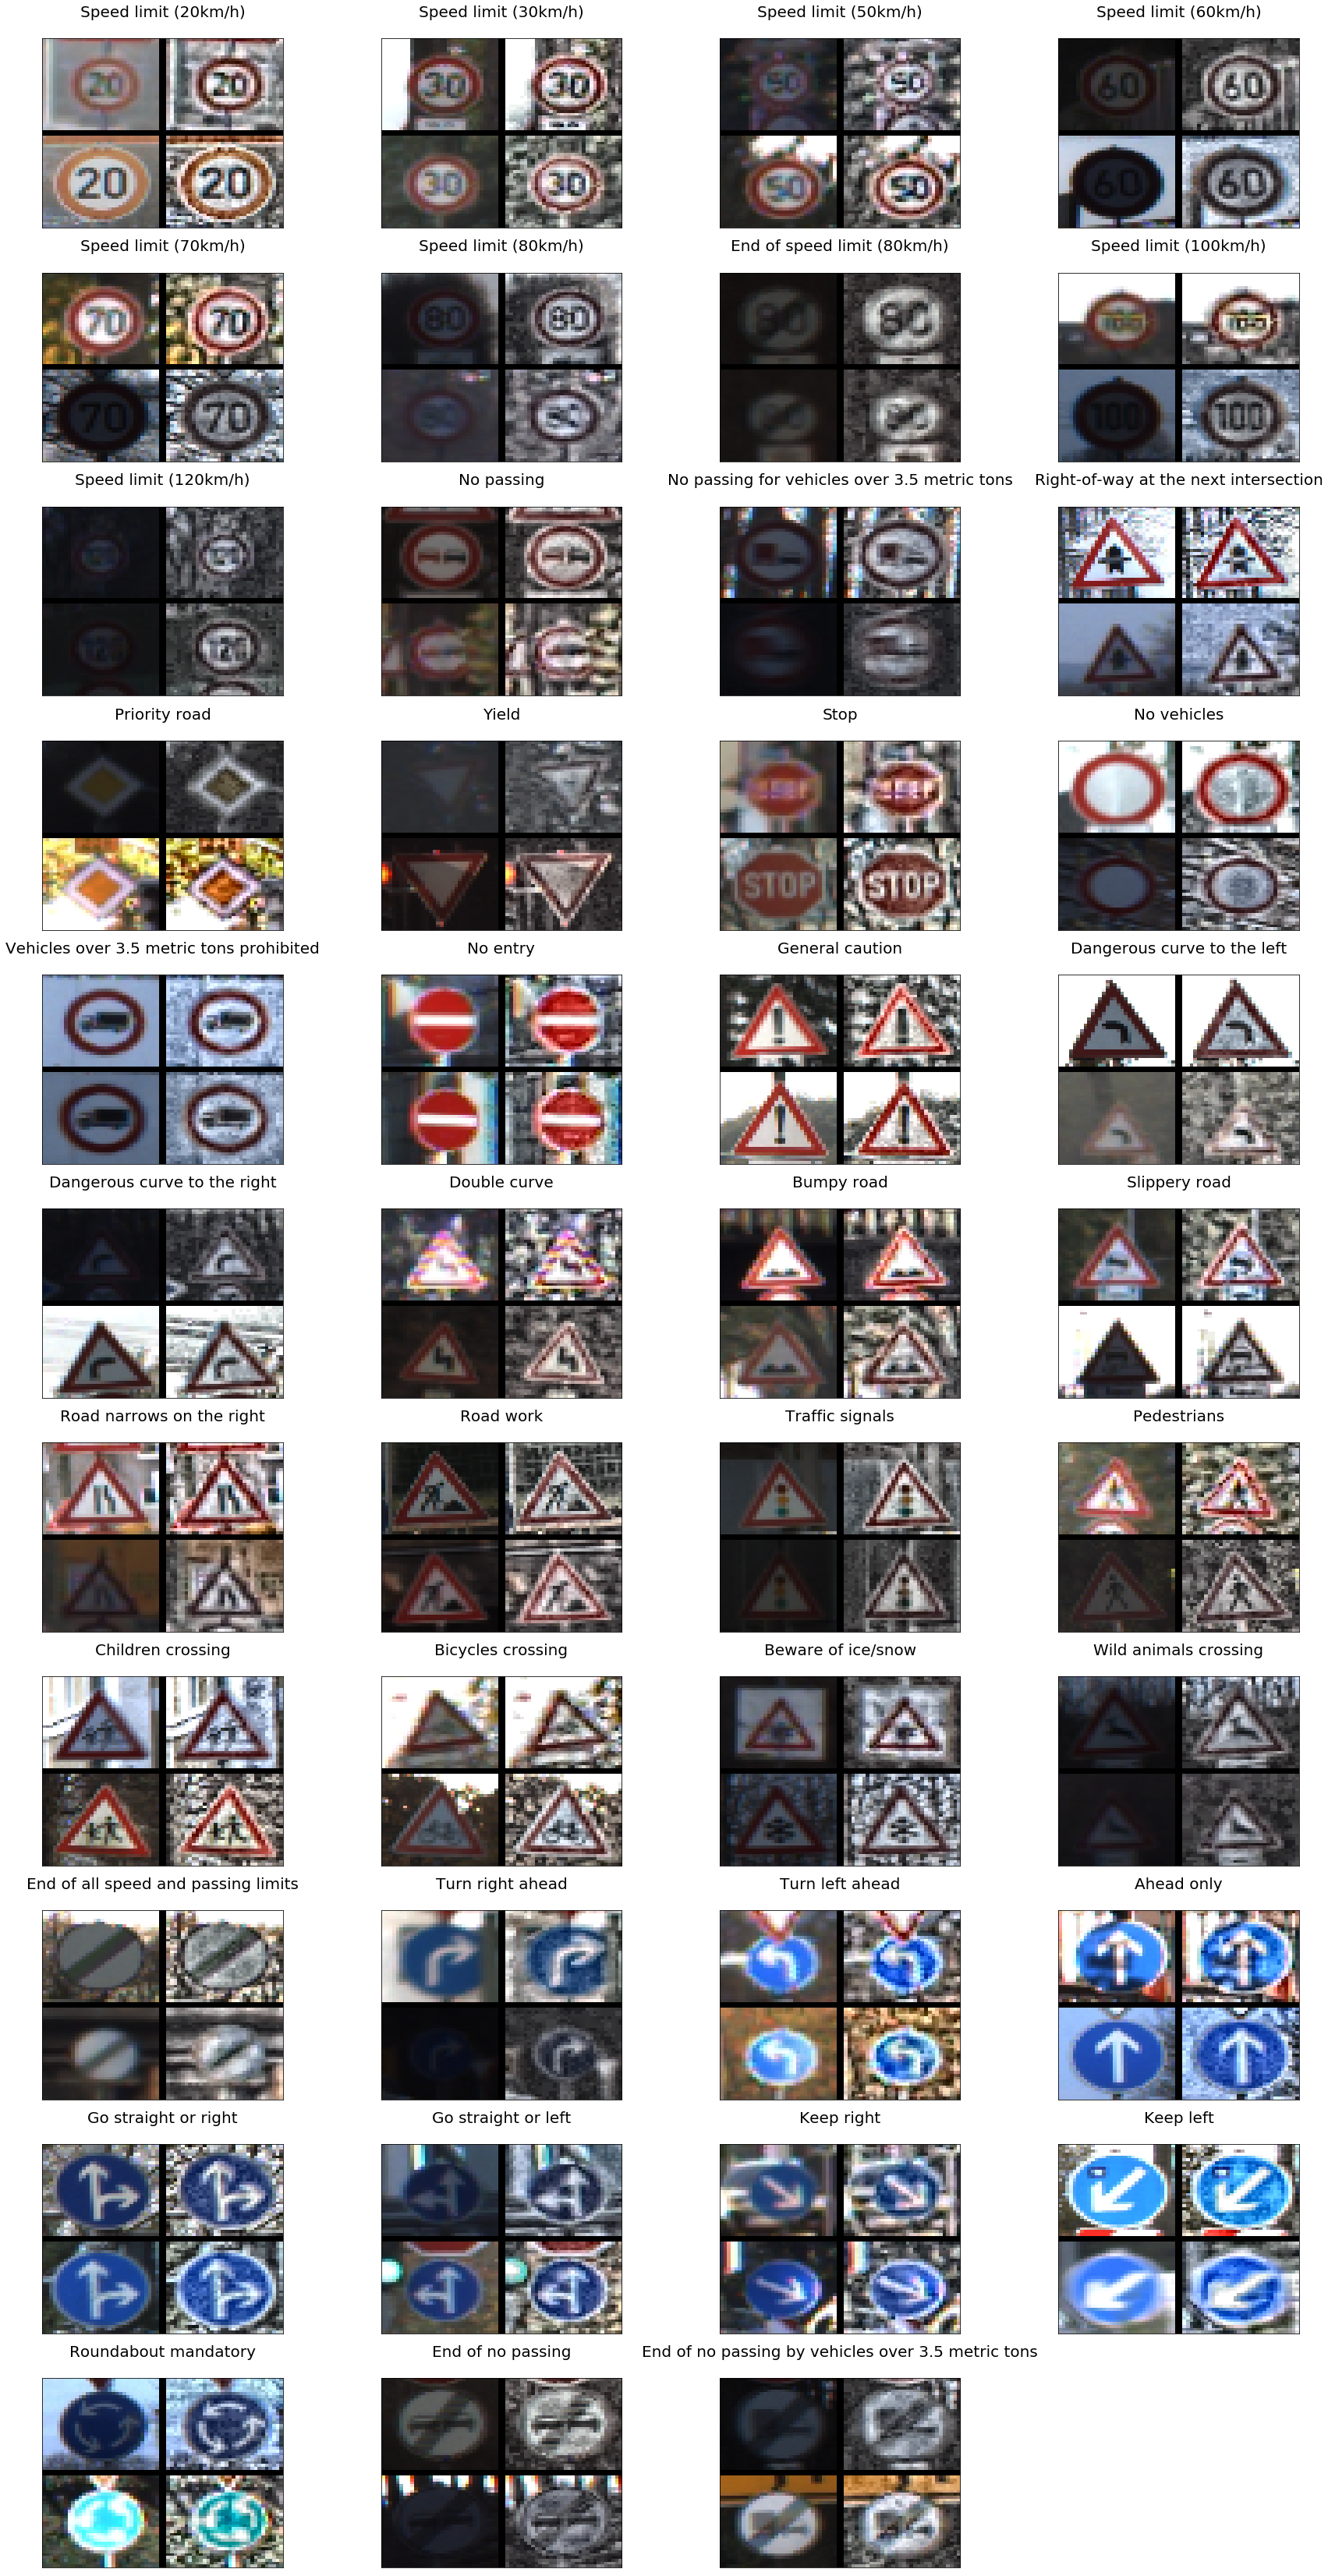

In [4]:
import numpy as np
def preprocess(rgbImage):
    """preprocss rgbImage using CLAHE method.
    The RGB image is first transformed into YUV space. Then, CLAHE is applied to
    the Y channel while UV channel is unchanged.
    Args:
        rgbImage: raw rgb image
    Returns:
        yuvImage: normalized yuv image
    """
    # convert image to yuv color space
    yuvImage = cv2.cvtColor(rgbImage,cv2.COLOR_RGB2YUV)
    Y = yuvImage[:,:,0].copy();
    clahe = cv2.createCLAHE(clipLimit=1, tileGridSize=(8,8))
    yuvImage[:,:,0] = clahe.apply(Y)
    return yuvImage
    
# show how the image changes after preprocessing
# for each image, we showed the preprocessed result on its right
fig4 = plt.figure(num=4, figsize=[24,46])
gs = gridspec.GridSpec(11, 4)
ax=[]
for ci in range(n_classes):
    row = (ci // 4)
    col = ci % 4
    # random choose images without replacement
    cidx = np.random.choice(idxOfEachClass[ci],2,replace=False)
    Image = np.zeros([66,66,3],dtype=np.uint8)
    # put small images into large images
    Image[0:32,0:32,:] = X_train[cidx[0],:,:,:]
    Image[0:32,34:66,:] = cv2.cvtColor(preprocess(X_train[cidx[0],:,:,:]),cv2.COLOR_YUV2RGB)
    Image[34:66,0:32,:] = X_train[cidx[1],:,:,:]
    Image[34:66,34:66,:] = cv2.cvtColor(preprocess(X_train[cidx[1],:,:,:]),cv2.COLOR_YUV2RGB)
    ax.append(fig4.add_subplot(gs[row, col]))
    ax[-1].set_title(idx2name[ci],{'fontsize':20})
    ax[-1].imshow(Image,interpolation='nearest',aspect='auto')
    ax[-1].get_xaxis().set_visible(False)
    ax[-1].get_yaxis().set_visible(False)
fig4.tight_layout()

### Show Jitter Effect
The training data set is small for CNN. We usually augument the dataset by jittering the raw image. We employed the jittering method mentioned in the [paper](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It randomly rotates the image in between [-15,15] degrees, scales the image in between [0.85,1.15] and randomly move the image in x and y direction [-4,4] pixels. 

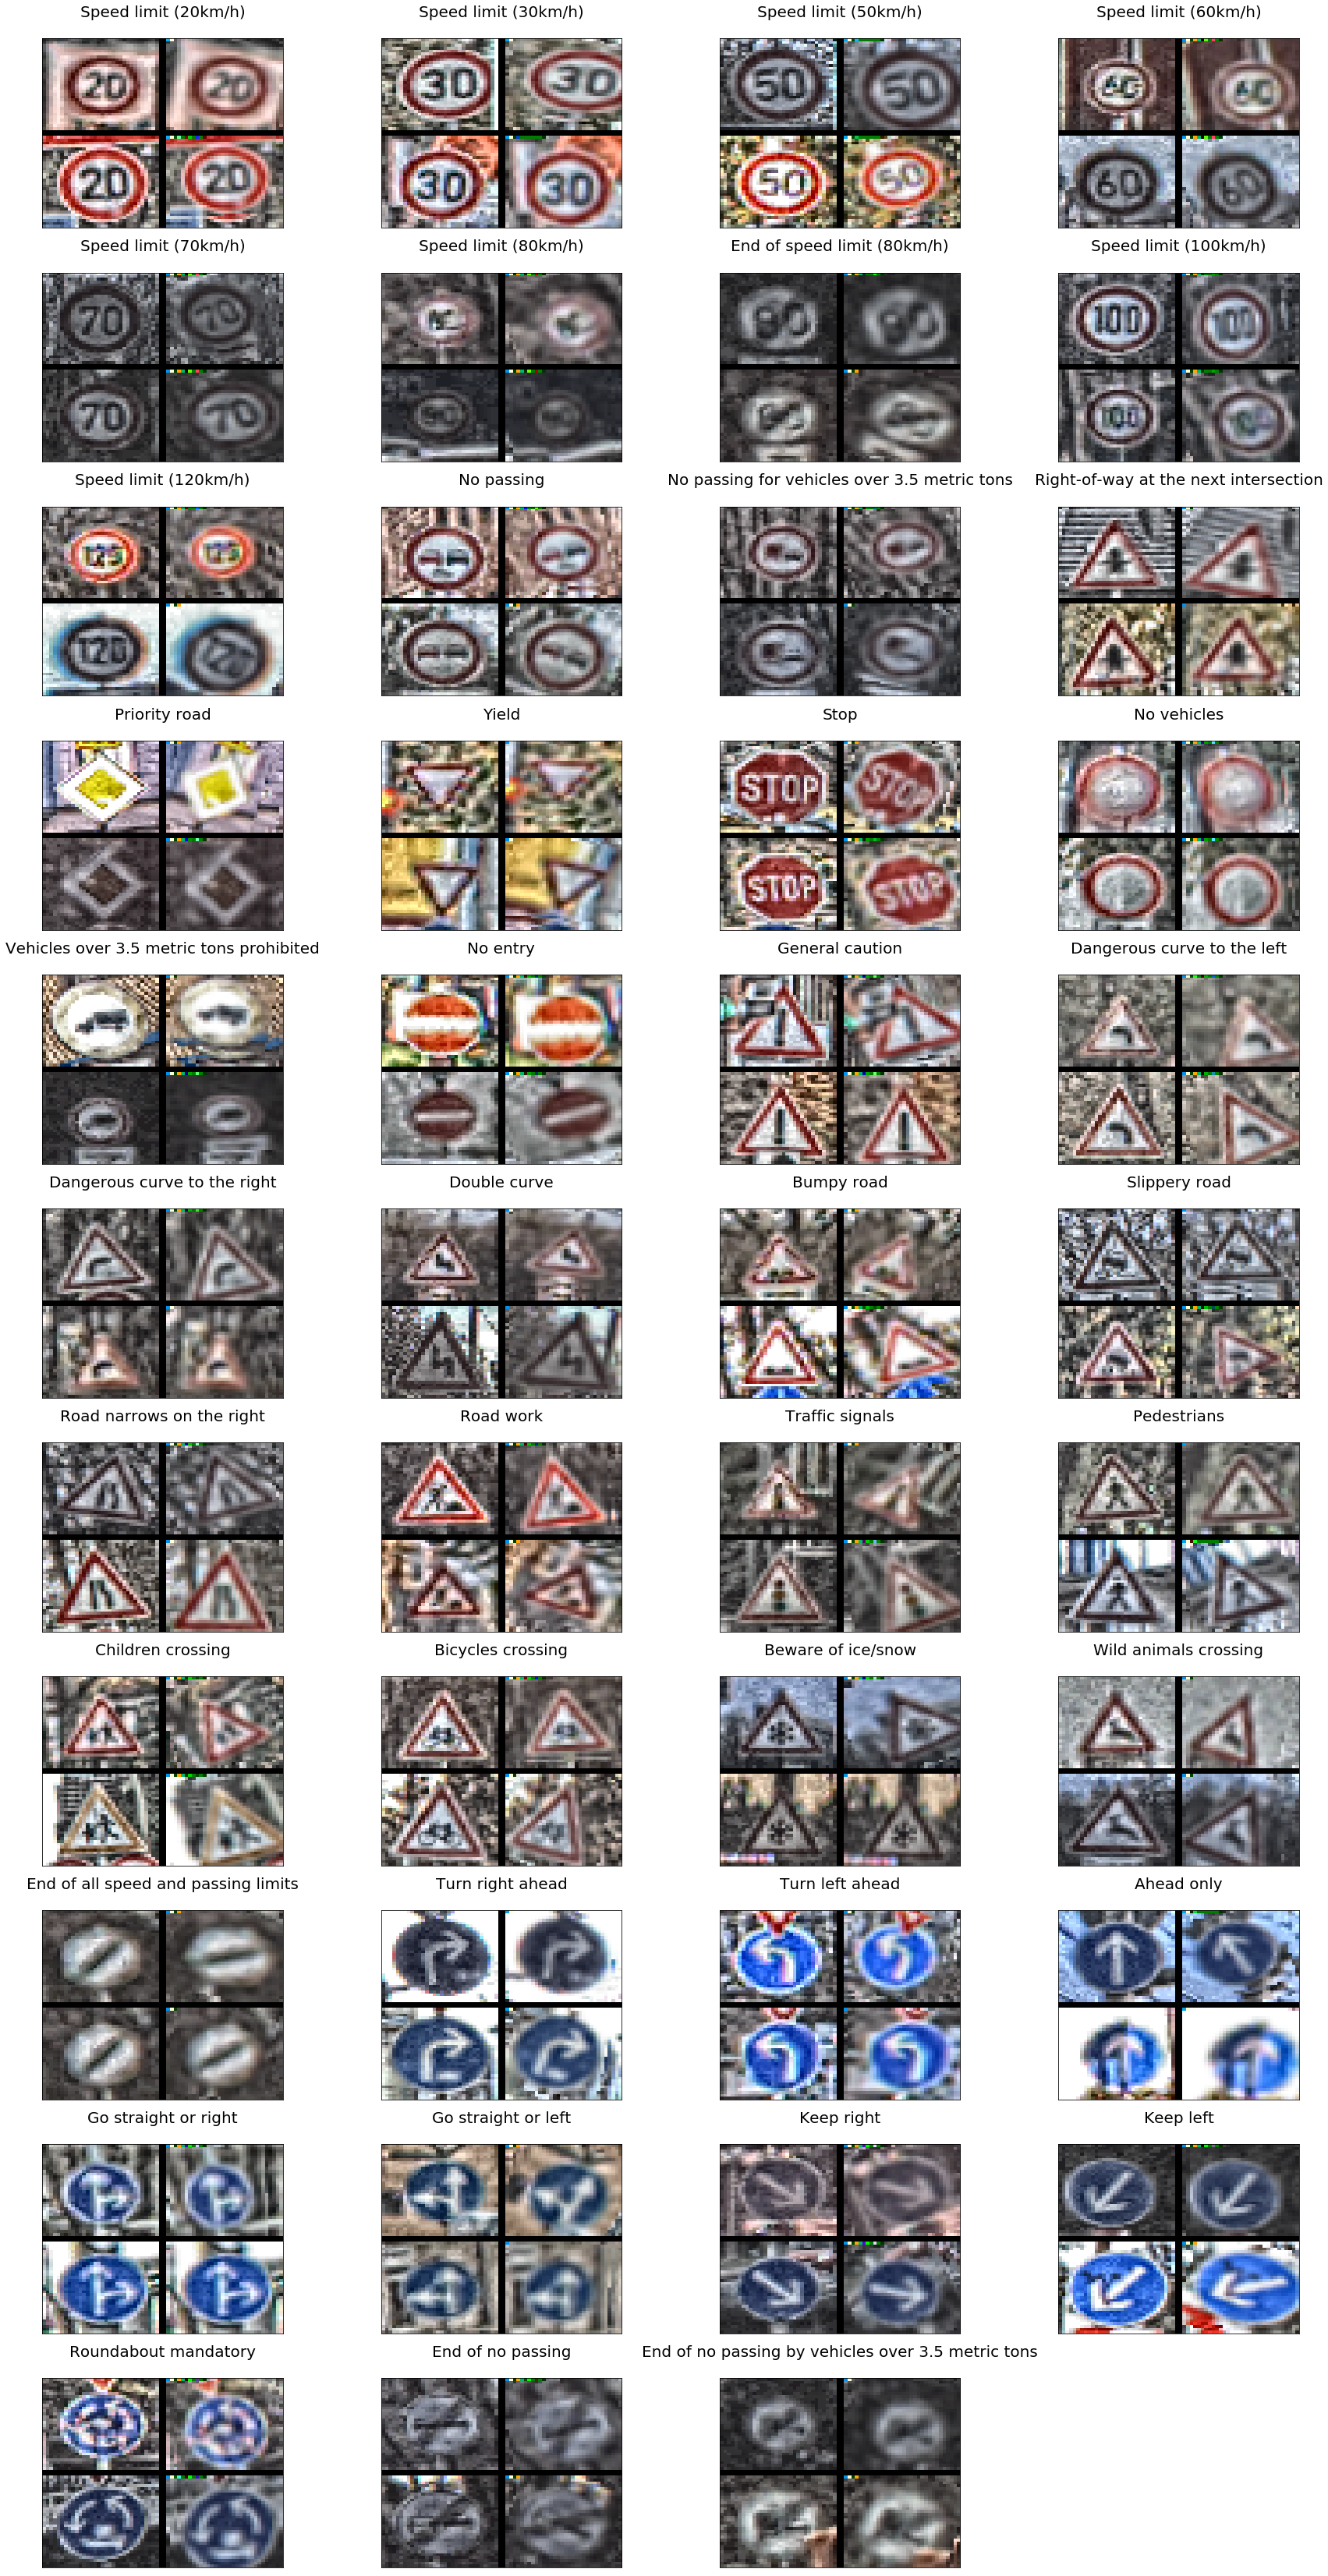

In [5]:
def jitterImage(I):
    """ perturb the image.
    rotating it by between [-15,15],
    Randomly jitter image by scaling it by between [0.85,1.15], 
    change position by [-4,4]
    Args:
        I: input image
    Returns:
        jitteredI: jittered image
    """
    cols = I.shape[1]
    rows = I.shape[0]
    # rotation
    dst = I.copy()
    theta = random.uniform(-16,16)
    R = cv2.getRotationMatrix2D((cols/2,rows/2),theta,1)
    dst = cv2.warpAffine(I,R,(cols,rows),dst,borderMode=cv2.BORDER_TRANSPARENT,flags=cv2.INTER_CUBIC)
    # scale
    fx = random.uniform(0.85,1.15)
    fy = random.uniform(0.85,1.15)
    dst = cv2.resize(dst,(0,0),dst,fx,fy)
    # transformation
    xdisplacement = random.uniform(-4, 4)
    ydisplacement = random.uniform(-4, 4)
    M = np.float32([[1,0,xdisplacement],[0,1,ydisplacement]])
    dst = cv2.warpAffine(dst,R,(cols,rows),dst,borderMode=cv2.BORDER_TRANSPARENT)
    return dst
    
# show how the image changes after jittering
# the jittered result is shown to the right of the original image
fig5 = plt.figure(num=5, figsize=[24,46])
gs = gridspec.GridSpec(11, 4)
ax=[]
for ci in range(n_classes):
    row = (ci // 4)
    col = ci % 4
    # random choose images without replacement
    cidx = np.random.choice(idxOfEachClass[ci],2,replace=False)
    Image = np.zeros([66,66,3],dtype=np.uint8)
    # put small images into large images
    Image[0:32,0:32,:] = cv2.cvtColor(preprocess(X_train[cidx[0],:,:,:]),cv2.COLOR_YUV2RGB)
    Image[0:32,34:66,:] = cv2.cvtColor(jitterImage(preprocess(X_train[cidx[0],:,:,:])),cv2.COLOR_YUV2RGB)
    Image[34:66,0:32,:] = cv2.cvtColor(preprocess(X_train[cidx[1],:,:,:]),cv2.COLOR_YUV2RGB)
    Image[34:66,34:66,:] = cv2.cvtColor(jitterImage(preprocess(X_train[cidx[1],:,:,:])),cv2.COLOR_YUV2RGB)
    ax.append(fig5.add_subplot(gs[row, col]))
    ax[-1].set_title(idx2name[ci],{'fontsize':20})
    ax[-1].imshow(Image,interpolation='nearest',aspect='auto')
    ax[-1].get_xaxis().set_visible(False)
    ax[-1].get_yaxis().set_visible(False)
fig5.tight_layout()

### Preprocess image, Split dataset and Generate new images for each image 
Note the dataset augmentation procedure takes considerable time. Therefore, to save time, We save the preprocessed and augmented dataset. When the files are detected, the preprocessing and augmentation step is skipped. 

Another thing is splitting the dataset into training and validation dataset. We uses the validation dataset to tune the hyperparameters like training epoches, weight decay paramter, CNN structure. Once we have set those hyperparamter, we could set the validation dataset to zeros and train on the whole training dataset.

In [6]:
import os
from sklearn.utils import shuffle
from numpy.random import permutation

## extract index in each class
idxOfEachClass=[[] for i in range(n_classes)]
for i in range(n_train):
    idxOfEachClass[y_train[i]].append(i)
    
## make validation dataset, we extract numValExamplesEachClass images from each class
## when tuning hyperparamters, set numValExamplesEachClass to 20 or 30.
## after you have fixed the hyperparameters, you could set numValExamplesEachClass to 0 
## to let training on the whole training dataset. 
numValExamplesEachClass = 0
validIdx = []
for i in range(n_classes):
    permutedIdx = permutation(idxOfEachClass[i]).tolist()
    validIdx.append(permutedIdx[0:numValExamplesEachClass])
    idxOfEachClass[i] = permutedIdx[numValExamplesEachClass:]
validIdx = sum(validIdx,[])
y_val = y_train[validIdx].copy()
X_val = X_train[validIdx,:,:,:].copy()


newIdx = idxOfEachClass.copy()
newIdx = sum(newIdx,[])
X_train = X_train[newIdx,:,:,:].copy()
y_train = y_train[newIdx].copy()

# check whether testing data data is processed and generated
if(not os.path.exists("./traffic-signs-data/preprocessedTest.p")):
    testData={}
    newX_test = X_test.copy()
    newy_test = y_test.copy()
    testData['features'] = newX_test
    testData['labels'] = newy_test
    for i in range(n_test):
        newX_test[i,:,:,:] = preprocess(X_test[i,:,:,:])
    with open("./traffic-signs-data/preprocessedTest.p", 'wb') as outfile:
        pickle.dump(testData, outfile, protocol=pickle.HIGHEST_PROTOCOL)

# check whether validation data data is processed and generated        
if(not os.path.exists("./traffic-signs-data/preprocessedVal.p")):
    valData={}
    ktimemore = 20
    n_val = len(y_val)
    newX_val = np.zeros(shape=(n_val*ktimemore,32,32,3),dtype=np.uint8)
    newy_val = np.zeros(shape=n_val*ktimemore,dtype=np.uint8)
    for i in range(len(y_val)):
        newX_val[i,:,:,:] = preprocess(X_val[i,:,:,:])
    for kk in range(1,ktimemore):
        for i in range(n_val):
            newX_val[i+kk*n_val,:,:,:] = preprocess(jitterImage(X_val[i,:,:,:]))
            newy_val[i+kk*n_val] = y_val[i]
    valData['features'] = newX_val
    valData['labels'] = newy_val
    with open("./traffic-signs-data/preprocessedVal.p", 'wb') as outfile:
        pickle.dump(valData, outfile, protocol=pickle.HIGHEST_PROTOCOL)

# check whether training data data is processed and generated
if(not os.path.exists("./traffic-signs-data/preprocessedTrain.p")):
    trainData={}
    ktimemore = 20
    n_train = len(y_train)
    
    newX_train = np.zeros(shape=(n_train*ktimemore,32,32,3),dtype=np.uint8)
    newy_train = np.zeros(shape=n_train*ktimemore,dtype=np.uint8)
    for i in range(n_train):
        newX_train[i,:,:,:] = preprocess(X_train[i,:,:,:])
        newy_train[i] = y_train[i]
    for kk in range(1,ktimemore):
        for i in range(n_train):
            newX_train[i+kk*n_train,:,:,:] = preprocess(jitterImage(X_train[i,:,:,:]))
            newy_train[i+kk*n_train] = y_train[i]
    trainData["features"] = newX_train
    trainData["labels"] = newy_train
    with open("./traffic-signs-data/preprocessedTrain.p", 'wb') as outfile:
        pickle.dump(trainData, outfile, protocol=pickle.HIGHEST_PROTOCOL)

## Step 2: load processed data

The previous step should be able to generate preprocessed and augmented dataset if they do not exist. 

In [7]:
# read data from the original dataset
training_file = './traffic-signs-data/preprocessedTrain.p'
testing_file = './traffic-signs-data/preprocessedTest.p'
val_file = './traffic-signs-data/preprocessedVal.p'
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
with open(val_file, mode='rb') as f:
     val = pickle.load(f)   
# get image and label
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
X_val, y_val = val['features'],val['labels']
n_classes = len(set(y_train))
n_train = X_train.shape[0]
n_test = X_test.shape[0]
n_val = X_val.shape[0]

# read csv file with name for each class
idx2name = []
with open('./signnames.csv', 'r') as csvfile:
    # skip header
    csvfile.readline()
    lines = csvfile.readlines()
    for line in lines:
        idx2name.append(line.split(',')[1])


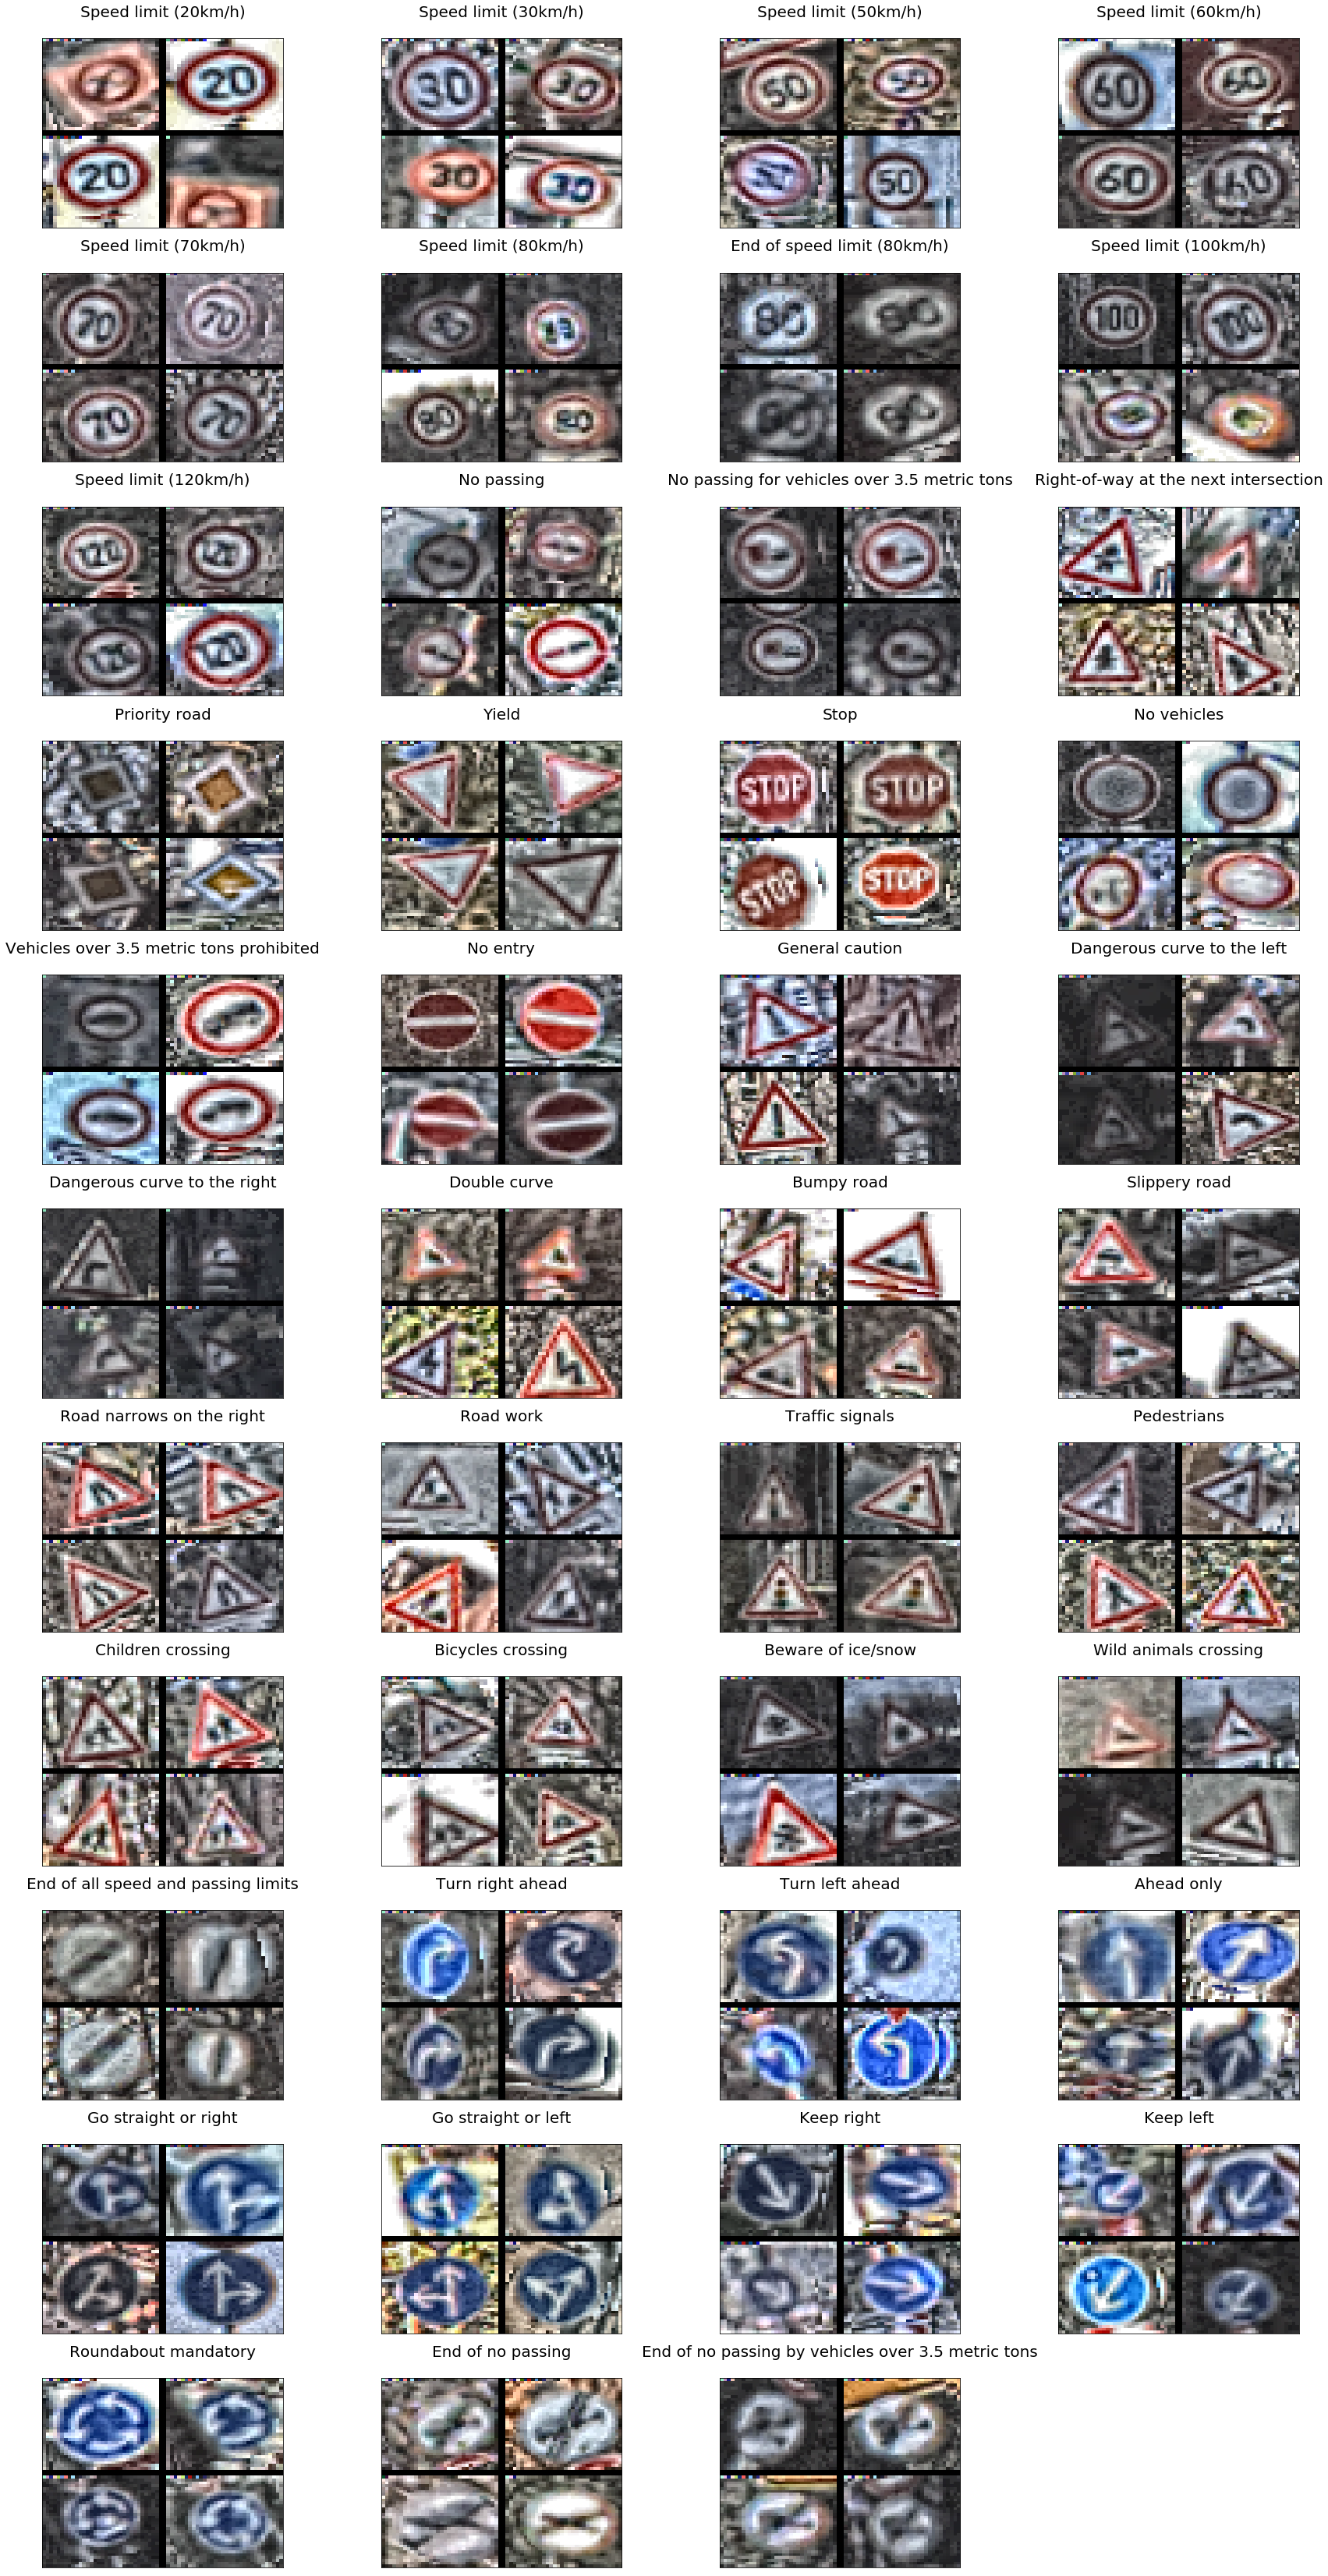

In [8]:
## extract index in each class
idxOfEachClass=[[] for i in range(n_classes)]
for i in range(n_train):
    idxOfEachClass[y_train[i]].append(i)
# draw images in the training dataset
fig1 = plt.figure(num=1, figsize=[24,46])
gs = gridspec.GridSpec(11, 4)
ax=[]
for ci in range(n_classes):
    row = (ci // 4)
    col = ci % 4
    # random choose images without replacement
    cidx = np.random.choice(idxOfEachClass[ci],4,replace=False)
    Image = np.zeros([66,66,3],dtype=np.uint8)
    # put small images into large images
    Image[0:32,0:32,:] = cv2.cvtColor(X_train[cidx[0],:,:,:],cv2.COLOR_YUV2RGB)
    Image[34:66,0:32,:] = cv2.cvtColor(X_train[cidx[1],:,:,:],cv2.COLOR_YUV2RGB)
    Image[0:32,34:66,:] = cv2.cvtColor(X_train[cidx[2],:,:,:],cv2.COLOR_YUV2RGB)
    Image[34:66,34:66,:] = cv2.cvtColor(X_train[cidx[3],:,:,:],cv2.COLOR_YUV2RGB)
    ax.append(fig1.add_subplot(gs[row, col]))
    ax[-1].set_title(idx2name[ci],{'fontsize':20})
    ax[-1].imshow(Image,interpolation='nearest',aspect='auto')
    ax[-1].get_xaxis().set_visible(False)
    ax[-1].get_yaxis().set_visible(False)
fig1.tight_layout()


## Step 3: Define Network

In [9]:
from tensorflow.contrib.layers import flatten
import tensorflow as tf
def CCNNet(x,weight_decay,keep_prob):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x108.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 108), mean = mu, stddev = sigma ,name="conv1_W"))
    conv1_b = tf.Variable(tf.zeros(108), name = "conv1_b")
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    # Layer 1: ReLU Activation
    conv1 = tf.nn.relu(conv1)
    # Layer 1: Pooling. Input = 28x28x108. Output = 14x14x108.
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    # Layer 1: LRN
    lrn1 = tf.nn.lrn(pool1, 3, bias=1.0, alpha=0.001 / 9.0, beta=0.75)    
    # Layer 2: Convolutional. Input = 14x14x108. Output = 10x10x200.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 108, 200), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(200))
    conv2   = tf.nn.conv2d(lrn1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    # Layer 2: ReLUActivation
    conv2 = tf.nn.relu(conv2)
    # Layer 2: Pooling. Input = 10x10x200. Output = 5x5x200.
    pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    # Layer 2: LRN
    lrn2 = tf.nn.lrn(pool2, 3, bias=1.0, alpha=0.001 / 9.0, beta=0.75) 
    # Flatten.
    # flatten lrn2 size = 5000
    flatten_lrn2   = flatten(lrn2)
    # flatten lrn1  size = 5292
    flatten_lrn1 = flatten(tf.nn.max_pool(lrn1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID'))
    # concatenated layer size = 10292
    fc0 = tf.concat(1,[flatten_lrn1,flatten_lrn2])
    # Layer 3: Fully Connected. Input = 10292. Output = 200.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(10292, 200), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(200))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # ReLU Activation.
    fc1    = tf.nn.relu(fc1)
    # dropout 
    dropfc1 = tf.nn.dropout(fc1, keep_prob)
    
    # Layer 4: Fully Connected. Input = 200. Output = 100.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(200, 100), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(100))
    fc2    = tf.matmul(dropfc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 100. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(100, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [10]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
rate = tf.placeholder(tf.float32, shape=[])
weight_decay = tf.placeholder(tf.float32,shape=[])
keep_prob = tf.placeholder(tf.float32,shape=[])

In [11]:
logits = CCNNet(x,weight_decay,keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [12]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()
BATCH_SIZE = 10
def evaluate(X_data, y_data):
    num_examples = X_data.shape[0]
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        batch_x=batch_x.astype(np.float32)
        batch_x -= 128
        batch_x /= 255
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y,weight_decay:0,keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [13]:
import time
EPOCHS = 10
BATCH_SIZE = 128
learning_rate = 0.001
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    #saver.restore(sess, tf.train.latest_checkpoint('.'))
    num_examples = len(X_train)
    accuracy_train = []
    print("Training...")
    print()
    for i in range(EPOCHS):
        start = time.time()
        X_train, y_train = shuffle(X_train, y_train)
        num_examples = X_train.shape[0]
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            batch_x=batch_x.astype(np.float32)
            batch_x -= 128
            batch_x /= 255
            l=sess.run([training_operation,loss_operation,accuracy_operation], feed_dict={x: batch_x, 
                                                                       y: batch_y,
                                                                       rate:learning_rate,
                                                                       weight_decay:0.005,
                                                                       keep_prob:0.5},)
            accuracy_train.append(l[2])
            if((offset / 128)%1000 == 0):
                #validation_accuracy = evaluate(X_val, y_val)
                #print("Validation Accuracy = {:.3f}".format(validation_accuracy))
                print("Train Accuracy = {:.5f} loss = {:.5f}".format(np.mean(accuracy_train[-100:]),l[1]))
        learning_rate = learning_rate * 0.65
        saver.save(sess, 'tao')
        print("Model saved")


Training...

Train Accuracy = 0.03906 loss = 5.66010
Train Accuracy = 0.77297 loss = 0.63486
Train Accuracy = 0.89156 loss = 0.25926
Train Accuracy = 0.93297 loss = 0.30360
Train Accuracy = 0.94609 loss = 0.08732
Train Accuracy = 0.96188 loss = 0.14906
Train Accuracy = 0.96594 loss = 0.07573
Model saved
Train Accuracy = 0.96672 loss = 0.06141
Train Accuracy = 0.97992 loss = 0.10230
Train Accuracy = 0.98008 loss = 0.11422
Train Accuracy = 0.98242 loss = 0.07035
Train Accuracy = 0.98336 loss = 0.03047
Train Accuracy = 0.98312 loss = 0.02198
Train Accuracy = 0.98664 loss = 0.00504
Model saved
Train Accuracy = 0.98602 loss = 0.07323
Train Accuracy = 0.99172 loss = 0.02592
Train Accuracy = 0.99148 loss = 0.02402
Train Accuracy = 0.99172 loss = 0.00534
Train Accuracy = 0.99273 loss = 0.01655
Train Accuracy = 0.99227 loss = 0.00700
Train Accuracy = 0.99031 loss = 0.03932
Model saved
Train Accuracy = 0.99281 loss = 0.00326
Train Accuracy = 0.99531 loss = 0.00969
Train Accuracy = 0.99508 loss =

In [14]:

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.985
